In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

df = pd.read_excel(r"C:\Users\jki\Downloads\Online Retail.xlsx")


In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
# explore and clean the dataset
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
# to check on the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [10]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [12]:
# Drop rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

In [13]:
# Remove rows with negative Quantity and Price
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [14]:
df['CustomerID'] = df['CustomerID'].astype(int)

In [16]:
# Verify the data type conversion
print(df.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int32
Country                object
dtype: object


In [17]:
#  Step 4 – Compute Recency, Frequency, and Monetary Value

snapshot_date = max(df['InvoiceDate']) + pd.DateOffset(days=1)

In [18]:
# Next, create a “Total” column that contains Quantity*UnitPrice for all the records:

df['Total'] = df['Quantity'] * df['UnitPrice']

In [19]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Total': 'sum'
})

In [20]:
# Let’s rename the columns for readability:
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Total': 'MonetaryValue'}, inplace=True)
rfm.head()


,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


In [21]:
#  Step 5 – Map RFM Values onto a 1-5 Scale 
rfm.describe()
    

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


In [22]:
# Calculate custom bin edges for Recency, Frequency, and Monetary scores
recency_bins = [rfm['Recency'].min()-1, 20, 50, 150, 250, rfm['Recency'].max()]
frequency_bins = [rfm['Frequency'].min() - 1, 2, 3, 10, 100, rfm['Frequency'].max()]
monetary_bins = [rfm['MonetaryValue'].min() - 3, 300, 600, 2000, 5000, rfm['MonetaryValue'].max()]

In [23]:
# Now that we’ve defined the bin edges, let’s map the scores to corresponding labels between 1 and 5 (both inclusive):

# Calculate Recency score based on custom bins 
rfm['R_Score'] = pd.cut(rfm['Recency'], bins=recency_bins, labels=range(1, 6), include_lowest=True)

# Reverse the Recency scores so that higher values indicate more recent purchases
rfm['R_Score'] = 5 - rfm['R_Score'].astype(int) + 1


# Calculate Frequency and Monetary scores based on custom bins
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=frequency_bins, labels=range(1, 6), include_lowest=True).astype(int)
rfm['M_Score'] = pd.cut(rfm['MonetaryValue'], bins=monetary_bins, labels=range(1, 6), include_lowest=True).astype(int)


In [24]:
# Print the first few rows of the RFM DataFrame to verify the scores
print(rfm[['R_Score', 'F_Score', 'M_Score']].head(10))

            R_Score  F_Score  M_Score
CustomerID                           
12346             1        1        5
12347             5        3        4
12348             3        3        3
12349             5        1        3
12350             1        1        2
12352             4        3        4
12353             2        1        1
12354             2        1        3
12355             2        1        2
12356             4        2        4


In [27]:
# Step 6 – Perform K-Means Clustering
# Extract RFM scores for K-means clustering
X = rfm[['R_Score', 'F_Score', 'M_Score']]

In [29]:
# Calculate inertia (sum of squared distances) for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

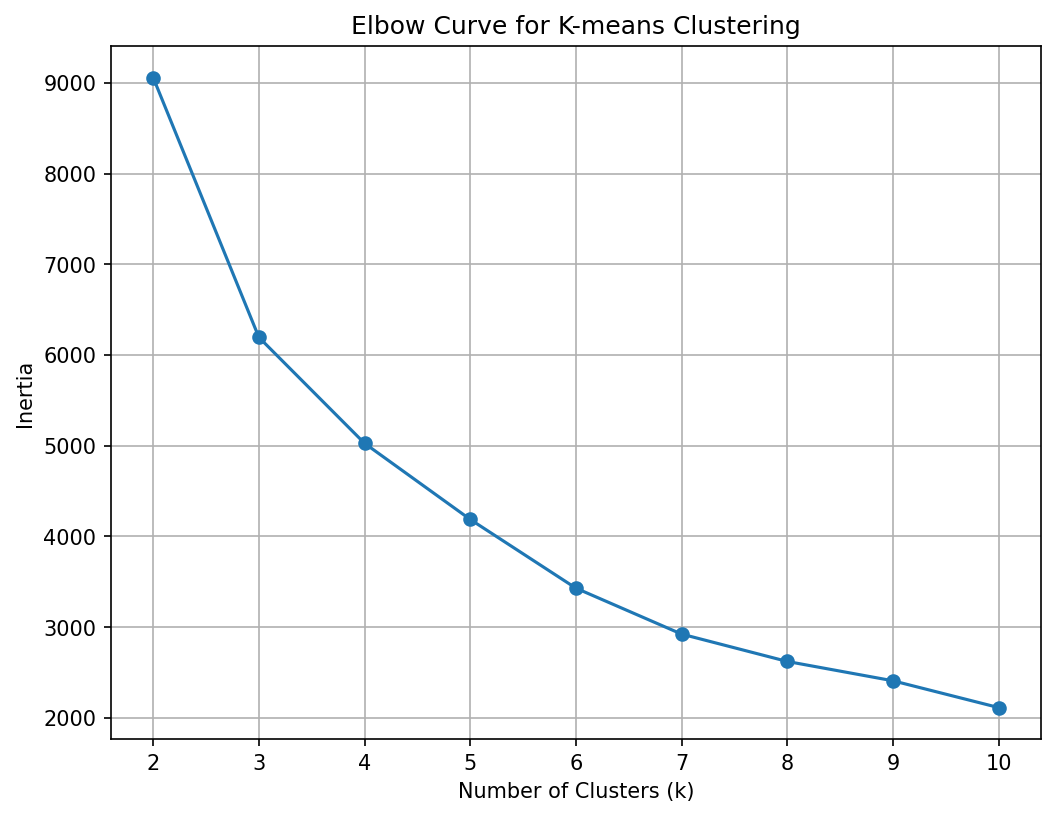

In [30]:
# Plot the elbow curve
plt.figure(figsize=(8, 6),dpi=150)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

In [31]:
# Perform K-means clustering with best K
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(X)

In [39]:
# Step 7 – Interpret the Clusters to Identify Customer Segments 
# Group by cluster and calculate mean values
cluster_summary = rfm.groupby('Cluster').agg({
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).reset_index()

In [41]:
print(cluster_summary)

   Cluster   R_Score   F_Score   M_Score
0        0  2.912809  1.980624  3.117330
1        1  1.797309  1.056502  1.385650
2        2  4.664587  3.179407  3.765991
3        3  4.108696  1.083004  1.878458


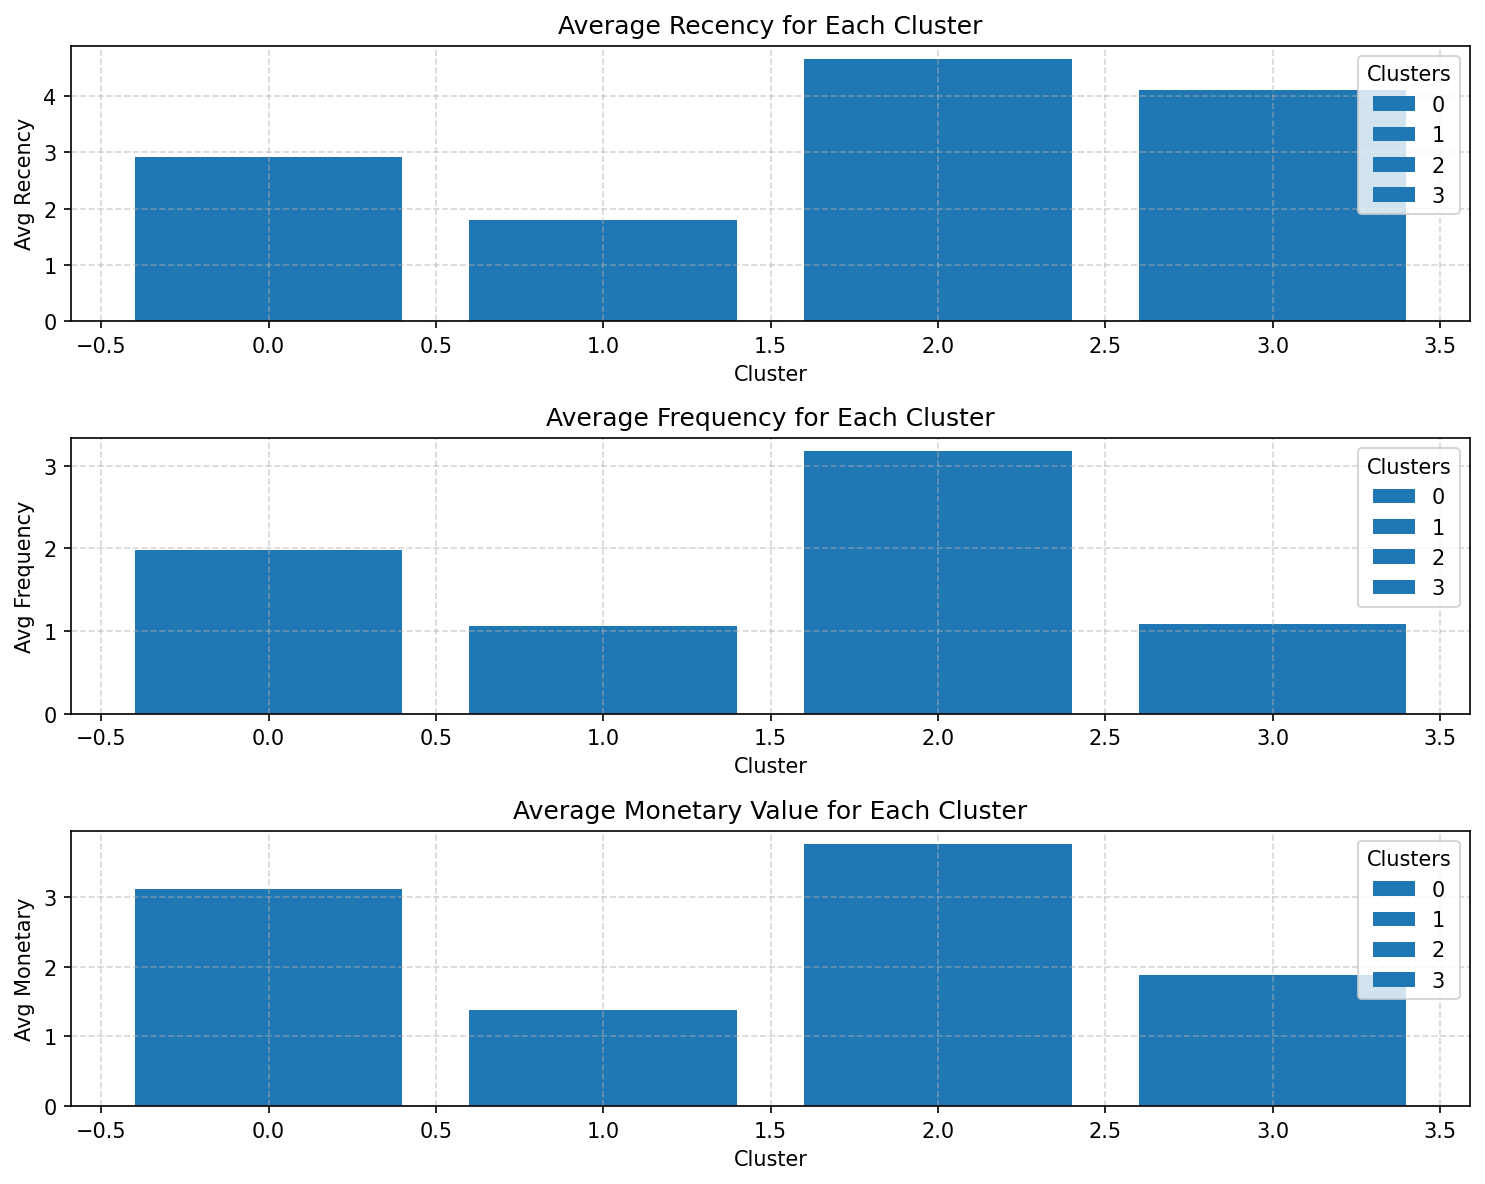

In [45]:
# But let’s visualize the average R, F, and M scores for the clusters so it’s easy to interpret:

# Plot the average RFM scores for each cluster
plt.figure(figsize=(10, 8),dpi=150)

# Plot Avg Recency
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary['R_Score'])
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('Average Recency for Each Cluster')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Frequency
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary['F_Score'])
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.title('Average Frequency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Monetary
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary['M_Score'])
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary')
plt.title('Average Monetary Value for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.tight_layout()
plt.show()


In [ ]:
# Let’s visualize the distribution of the different clusters using a pie chart
